---
title: Visualising Earthquakes in Nepal
date: '2024-10-15'
categories:
  - GIS
  - earthquakes
---

In this notebook, we will analyse the earthquakes that occurred in Nepal since 2010. 

# Getting the Data

The USGS provides free access to the earthquake data via the [Earthquake Catalog](https://earthquake.usgs.gov/earthquakes/search/) API. 

The API supports a number of query parameters, but we need only a subset of those, particularly to limit the search to Nepal's geographical bounds and since 2010. We'll also limit the results to include earthquakes > 3 in magnitude. It can return the data in a number of formats (including CSV and GeoJSON), here we'll use the GeoJSON format.

We need to provide the geographical bounds (min/max latitude and longitude) of the area for which to get the data; the API doesn't support filtering by country. To this end, let's read a *GeoJSON* file of the administrative boundaries from the [*geoBoundaries*](https://github.com/wmgeolab/geoBoundaries) project on GitHub.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# get the national boundary of Nepal
boundary_url = "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/refs/heads/main/releaseData/gbOpen/NPL/ADM0/geoBoundaries-NPL-ADM0.geojson"
nepal = gpd.read_file(boundary_url)

Now, we can read the data from the API.

In [2]:
import pandas as pd
import urllib.parse
import datetime

bounds = nepal.bounds
minx, miny, maxx, maxy = bounds.iloc[0].to_numpy()

CATALOG_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson"
params = {
    "starttime": "2010-01-01",
    "endtime": str(datetime.date.today()),
    "maxlatitude": maxy,
    "minlatitude": miny,
    "maxlongitude": maxx,
    "minlongitude": minx,
    "minmagnitude": 4,
    "eventtype": "earthquake",
    "orderby": "time",
}
columns = ["mag", "place", "time", "geometry"]

url = f"{CATALOG_URL}?{urllib.parse.urlencode(params)}"
quakes = gpd.read_file(url, columns=columns)

quakes.head()

,mag,place,time,geometry
0,4.4,"148 km E of Saga, China",1745838013982,POINT Z (86.7587 29.2963 10)
1,4.2,"138 km N of Lobuche, Nepal",1745193803011,POINT Z (86.9874 29.1891 2.847)
2,4.2,"93 km ENE of Lobuche, Nepal",1744755636029,POINT Z (87.7324 28.1352 71.393)
3,4.3,"81 km NE of Lobuche, Nepal",1744365447572,POINT Z (87.2746 28.557 10)
4,4.2,"115 km N of Lobuche, Nepal",1744261947380,POINT Z (86.6178 28.9806 10)


Let's make some changes to the `quakes` dataframe here:

1. convert the time to pandas' *datetime* type. The time is currently in *UTC*, so we'll also convert that to *'Asia/Kathmandu'*,
1. set the CRS to be the same as the `nepal` geodataframe, *WebMercator*, and
1. extract the *latitude* and *longitude* from the `geometry` to work better with `matplotlib`.

In [3]:
# 1.
quakes["time"] = (
    pd.to_datetime(quakes["time"], unit="ms")
    .dt.tz_localize("UTC")
    .dt.tz_convert("Asia/Kathmandu")
)

# 2.
quakes = quakes.to_crs(nepal.crs)

# 3.
quakes = quakes.join(
    quakes.get_coordinates().rename(columns=dict(x="longitude", y="latitude"))
)

quakes.head()

,mag,place,time,geometry,longitude,latitude
0,4.4,"148 km E of Saga, China",2025-04-28 16:45:13.982000+05:45,POINT Z (86.7587 29.2963 10),86.7587,29.2963
1,4.2,"138 km N of Lobuche, Nepal",2025-04-21 05:48:23.011000+05:45,POINT Z (86.9874 29.1891 2.847),86.9874,29.1891
2,4.2,"93 km ENE of Lobuche, Nepal",2025-04-16 04:05:36.029000+05:45,POINT Z (87.7324 28.1352 71.393),87.7324,28.1352
3,4.3,"81 km NE of Lobuche, Nepal",2025-04-11 15:42:27.572000+05:45,POINT Z (87.2746 28.557 10),87.2746,28.5570
4,4.2,"115 km N of Lobuche, Nepal",2025-04-10 10:57:27.380000+05:45,POINT Z (86.6178 28.9806 10),86.6178,28.9806


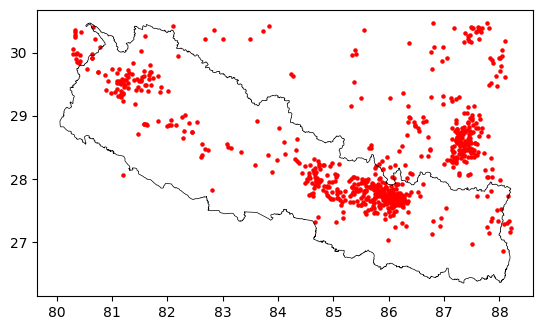

In [4]:
ax = nepal.boundary.plot(color="black", linewidth=0.5)
quakes.plot(ax=ax, markersize=5, color="red")
plt.show()

# Filtering the results

We can see that the results include all earthquakes located within the rectangular geogrpahical bounds we provided to the API; there are many earthquakes recorded in China and a few in India that we want to filter out.

To fix this, we'll use the `within` function provided by `geopandas` to filter only those within Nepal's boundary.

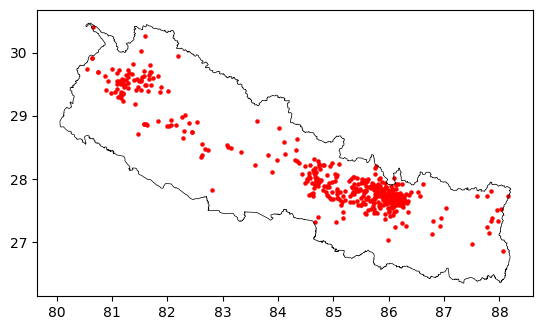

In [5]:
quakes = quakes[quakes.within(nepal.iloc[0].geometry)]
ax = nepal.boundary.plot(color="black", linewidth=0.5)
quakes.plot(ax=ax, markersize=5, color="red")
plt.show()

# Earthquakes by recency and magnitude

Now that we have filtered the earthquakes to those that occurred within Nepal's boundaries, we can improve the above map by indicating:

1. the strength of the earthquake (*magnitude*):\n
    Earthquake magnitudes are logarithmic in nature; for example, a magnitude 7 earthquake is 10 times stronger than a magnitude 6 one. To visualise this, I have used the following formula to calculate the marker size for the earthquakes.

    $marker\_size = base\_size \times 10^{(magnitude - base\_magnitude)}$
    
1. when the earthquake took place (*time*):\n
    We'll use the *RdPu* colormap; the points for earlier earthquakes are lighter and the more recent ones are dark purple. And we'll also bin the time by year, so in this case we have a segmented colormap.

Instead of the default plotting feature of `geopandas` we'll utilise the flexibility of `matplotlib` to achieve the above. 

In [6]:
base_size = 1
base_magnitude = 4
marker_sizes = base_size * (10 ** (quakes["mag"] - base_magnitude))

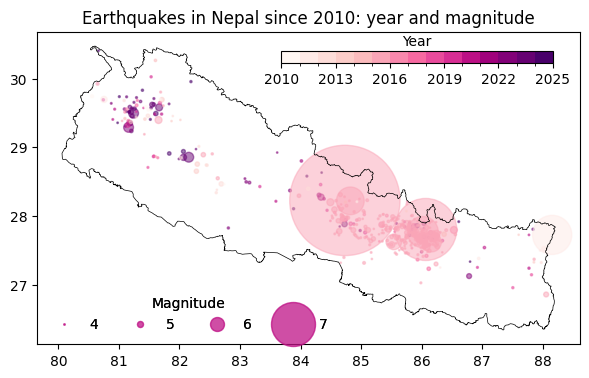

In [7]:
# | classes: preview-image

import numpy as np
import matplotlib as mpl

# use only the year - for a segmented colormap
quakes.loc[:, "year"] = quakes["time"].dt.year

# customise the colormap for our year extents
cmap = plt.get_cmap("RdPu")
bounds = sorted(quakes["year"].unique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(7, 7))
nepal.boundary.plot(color="black", linewidth=0.5, ax=ax)

# draw the point plot on the map
points = ax.scatter(
    quakes["longitude"],
    quakes["latitude"],
    s=marker_sizes,
    alpha=0.5,
    c=quakes["year"],
    cmap=cmap,
    norm=norm,
)

# produce a legend with a cross-section of sizes from the scatter plot
# 1. here we reverse the size function from above so the legend values match the magnitude
kw = dict(
    prop="sizes",
    num=4,
    color=points.cmap(0.7),
    func=lambda s: np.log10(s / base_size) + base_magnitude,
)

# 2. then we create a custom legend for the size
legend = ax.legend(
    *points.legend_elements(**kw),
    loc="lower left",
    title="Magnitude",
    ncols=4,
    frameon=False,
)

# 3. and finally add our legend to the plot
ax.add_artist(legend)

# create a colorbar corresponding to the year bins
# 1. we create an inset axis so we can place the colorbar within the map frame, instead of the default placement outside the frame
cax = ax.inset_axes([0.45, 0.9, 0.5, 0.04])

# 2. use the segmented colormap and normalisation created earlier
cb = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cax,
    fraction=0.02,
    shrink=0.5,
    label="Year",
    location="bottom",
    ticks=[2010, 2013, 2016, 2019, 2022, 2025],
)
cb.ax.xaxis.set_label_position("top")

ax.set_title("Earthquakes in Nepal since 2010: year and magnitude")
plt.show()

We can also visualise distribution of the earthquakes by time and magnitude. We can see that, with the exception of the earthquakes in 2015, most earthqukes are in the 4-5 magnitude range.

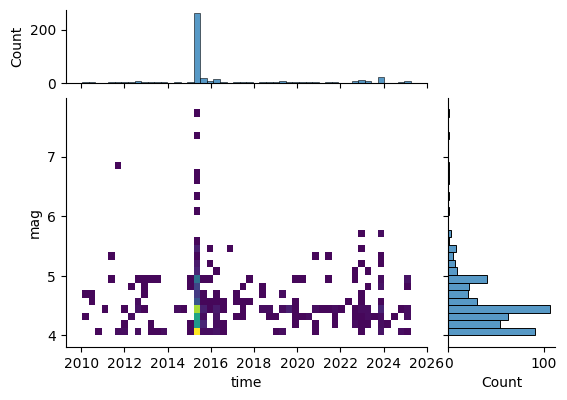

In [8]:
import seaborn as sns

grid = sns.jointplot(
    quakes,
    x="time",
    y="mag",
    kind="hist",
    height=5,
    ratio=3,
    marginal_ticks=True,
    palette="Set2",
    cmap="viridis",
)

# jointplots are square in seaborn, we need a hacky way to change the dimensions.
grid.fig.set_figheight(4)
grid.fig.set_figwidth(6)
plt.show()

Given the unusually high number of earthquakes in 2015, let's remove the data for 2015, and see what the rest looks like. Visually, there doesn't seem any significant variation in the number of earthquakes observed in a year.

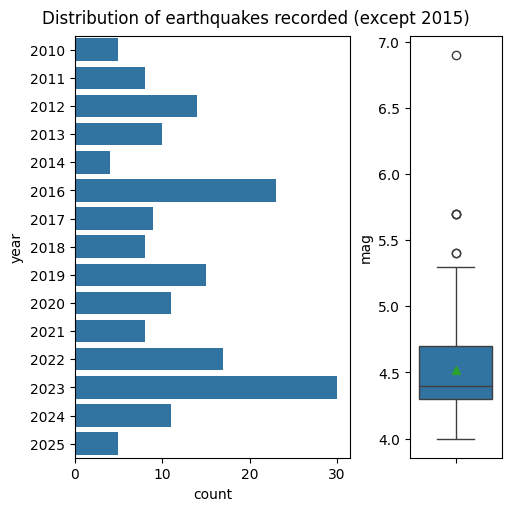

In [9]:
without_2015 = quakes[quakes["year"] != 2015]

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(5, 5), width_ratios=[3, 1], layout="constrained"
)
sns.barplot(
    without_2015.groupby(["year"]).size().reset_index(name="count"),
    y="year",
    x="count",
    orient="y",
    ax=ax1,
)
sns.boxplot(without_2015, y="mag", ax=ax2, showmeans=True)

fig.suptitle("Distribution of earthquakes recorded (except 2015)")

plt.show()

# The 2015 earthquake

Finally, let's look at the [2015 earthquake](https://en.wikipedia.org/wiki/April_2015_Nepal_earthquake). For this purpose, we'll filter the earthquakes between April-May 2015.
We'll also roughly filter only those within certain bounds.

In [10]:
from shapely import Polygon

coords = ((84, 29), (84, 27), (87, 27), (87, 29))
quakes_2015 = quakes.set_index("time").sort_index().loc["2015-04-01":"2015-05-31"]
quakes_2015 = quakes_2015[quakes_2015.within(Polygon(coords))]

quakes_2015 = quakes_2015.sort_index()

Let's see how many earthquakes occurred each day during this period. And we can see that there were 71 earthquakes above 4 magnitude on the first day and 31 on the second day. On 05/12 when the largest aftershock happened, there were 51 earthquakes.

In [44]:
quakes_2015["mag"].groupby(pd.Grouper(freq="D")).count().sort_values(
    ascending=False
).head(10)

time
2015-04-25 00:00:00+05:45    71
2015-05-12 00:00:00+05:45    51
2015-04-26 00:00:00+05:45    31
2015-05-13 00:00:00+05:45    15
2015-04-27 00:00:00+05:45    11
2015-05-02 00:00:00+05:45     8
2015-04-29 00:00:00+05:45     5
2015-05-04 00:00:00+05:45     5
2015-05-16 00:00:00+05:45     4
2015-05-11 00:00:00+05:45     3
Name: mag, dtype: int64

Finally, lets plot the number and intensity of the earthquakes on 04/25, such that we can easily visualise when the earthquakes occurred.

A normal barplot with *matplotlib* will not space out the bars based on the time of day - all bars will be evenly spaced.
To achieve this, we will use *pandas* to set the frequency of the timestamp to 1 seconds and fill missing values with NaN.

In [13]:
# first day
s = quakes_2015.loc["2015-04-25", ["mag"]]

# set time freq to seconds
s.index = s.index.ceil(freq="s")

s1 = s.asfreq("1s")

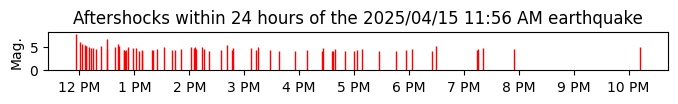

In [32]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(8, 0.5))

plt.bar(
    x=s1.index.tz_localize(None),
    height=s1.mag,
    width=0.5 * 1 / (24 * 60 * 60),
    edgecolor="red",
)

# Define the date format
date_form = DateFormatter("%-I %p")
ax.xaxis.set_major_formatter(date_form)
ax.set_ylabel("Mag.")

ax.set_title("Aftershocks within 24 hours of the 2025/04/15 11:56 AM earthquake")
plt.show()

And below is a slight variation of the above as a dense time series heatmap.

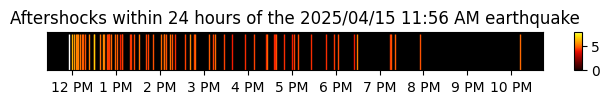

In [43]:
import colorcet as cc

fig, ax = plt.subplots(figsize=(8, 0.5))

cmap = plt.get_cmap("cet_fire")
min_mag, max_mag = 0, s1.mag.max()
rescale = lambda y: (y - min_mag) / (max_mag - min_mag)
colours = cmap(rescale(s1.mag))
bars = plt.bar(
    x=s1.index.tz_localize(None), height=1, width=0, linewidth=1, edgecolor=colours
)

# Define the date format
date_form = DateFormatter("%-I %p")
ax.xaxis.set_major_formatter(date_form)
ax.set_facecolor("black")

ax.set_yticks([])

# colorbar
norm = plt.Normalize(min_mag, max_mag)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, aspect=5)
cbar.ax.xaxis.set_label_position("top")

ax.set_title("Aftershocks within 24 hours of the 2025/04/15 11:56 AM earthquake")
plt.show()